## Artificial Intelligence | 4022 | Dr. Fadaei
## Assignment #05
***
### Amirreza Akbari | 810899045
### 1402/03/19

# Install & Import Libraries

In [1]:
import importlib.util

required_libraries = ["numpy", "pandas", "matplotlib", "seaborn", "scikit-learn", "nltk", "emoji", "gensim", "torch", "tqdm"]

for lib in required_libraries:
    if importlib.util.find_spec(lib) is None:
        # Install the library
        !pip install {lib}

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from typing import Literal
from torch import nn
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import emoji
import os
import gensim
import gensim.downloader as api
import torch
import sklearn.metrics as metrics


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.4/431.4 kB 7.0 MB/s eta 0:00:00


# Part 0: Data Preparation

## 0.1. Preprocessing Function

In [2]:
# Define the required NLTK data
nltk_data = {
    'stopwords': 'corpora/stopwords',
    'punkt': 'tokenizers/punkt',
    'wordnet': 'corpora/wordnet.zip'
}

# Ensure all necessary NLTK data is downloaded
for data, resource in nltk_data.items():
    try:
        nltk.data.find(resource)
    except LookupError:
        nltk.download(data)

# Define stopwords and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()

    # Remove punctuation marks
    text = re.sub(r'[^\w\s]', ' ', text)

    # Remove numbers
    text = re.sub(r'\d+', ' ', text)

    # Remove links
    text = re.sub(r'http\S+|www\S+|https\S+', ' ', text, flags=re.MULTILINE)

    # Remove user references
    text = re.sub(r'@\w+', ' ', text)

    # Remove emojis
    text = emoji.demojize(text)

    # Unify white spaces
    text = re.sub(r'\s+', ' ', text).strip()

    # Eliminate non-word phrases
    text = re.sub(r'\W', ' ', text)

    # Tokenize
    tokens = word_tokenize(text)

    # Remove stop words and lemmatize the tokens
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words and token.isalpha()]

    return tokens


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


## QUESTION: Converting the text to lowercase

Advantages:
- **Normalization:** Converting text to lowercase standardizes the text, ensuring that words like "Apple" and "apple" are treated as the same word. This reduces the complexity and variability in the text data, making it easier to process and analyze.
- **Simplified Matching:** It simplifies string matching and comparisons, as we don't have to account for different capitalizations of the same word. This is particularly useful in natural language processing tasks where consistency is crucial.
- **Reduced Vocabulary Size:** By converting text to lowercase, the vocabulary size is reduced, which can help in improving the efficiency of the model. A smaller vocabulary means fewer parameters to learn, which can lead to faster training times and less computational resource usage.

Disadvantages:
- **Loss of Information:** Case sensitivity can sometimes carry important information, especially in Named Entity Recognition (NER) tasks. Some words may carry different meanings based on their capitalization (e.g., "Apple" (the company) vs. "apple" (the fruit)). Converting to lowercase can result in the loss of such distinctions, potentially impacting the understanding of the context.
- **Proper Nouns:** Capitalized words often represent proper nouns (names of people, places, organizations, etc.). Lowercasing these words can remove the indication that they are proper nouns, which might be relevant in some contexts.

Why We Do This Processing:
> We convert text to lowercase to simplify the text data, making it more consistent and easier to process. This step is typically done early in the preprocessing pipeline to ensure that all subsequent text manipulations operate on a normalized text format. Despite the potential loss of some context-specific information, the benefits of reducing variability and complexity in the text generally outweigh the disadvantages.


## QUESTION: Elimination of numbers

Advantages:
- **Noise Reduction:** Numbers in text can often be irrelevant to the task at hand and may introduce noise. Removing numbers can help in focusing on the meaningful words that contribute to the understanding of the text.
- **Simplified Tokenization:** By removing numbers, the tokenization process is simplified and focused on the actual textual content. Numbers can sometimes create challenges in tokenization, especially if they are part of words or phrases.
- **Reduced Vocabulary Size:** Eliminating numbers reduces the size of the vocabulary, similar to the effect of lowercasing. This can lead to more efficient processing and potentially faster training times for machine learning models.

Disadvantages:
- **Loss of Information:** Numbers can carry significant information, especially in certain contexts (e.g., dates, quantities, measurements). Removing them can lead to the loss of potentially valuable information.
- **Contextual Importance:** In some tasks, the presence and frequency of numbers might be crucial for understanding the text (e.g., financial documents, scientific papers). Removing numbers indiscriminately can negatively impact the performance of models in such tasks.

Why We Do This Processing:
> In many NLP tasks, especially those dealing with informal text like tweets, numbers often do not contribute to the understanding of the text's sentiment or intent. Therefore, removing numbers helps in simplifying the text and reducing noise, although this step should be carefully considered based on the specific task and dataset.


## QUESTION: Hashtags

Why We Keep Hashtags:
> Hashtags are not removed during preprocessing because they carry significant semantic information. On Twitter, hashtags are used to categorize content, highlight key themes, and connect tweets to broader conversations. They often summarize the main topic or sentiment of the tweet in a concise way.

Effect on Model Performance:
- **Improved Context Understanding:** Hashtags can provide additional context to the tweet, which is beneficial for models to understand the underlying topics or sentiments. For instance, a tweet with #MentalHealth can give a clear indication that the content is related to mental health.
- **Enhanced Feature Representation:** Including hashtags can enhance the feature representation of the text, as they can act as keywords that encapsulate the core message of the tweet. This can improve the model's ability to classify or analyze the text accurately.
- **Community and Trend Detection:** Hashtags help in identifying community-specific language and trending topics. They can be useful in understanding the social dynamics and temporal patterns in the data.

Potential Challenges:
- **Noisy Data:** Sometimes hashtags can be very specific or obscure, leading to increased noise in the data. This can potentially introduce irrelevant features if the hashtag usage is not consistent across the dataset.
- **Overfitting:** In some cases, models might overfit to specific hashtags, especially if they are very frequent or strongly correlated with particular labels. This can limit the model's generalizability to new, unseen data.


## 0.2. Apply Preprocessing

In [3]:
# Load dataset
file_path = 'twitter-suicidal-data.csv'
df = pd.read_csv(file_path)

# Apply preprocessing to the dataset
df['tokens'] = df['tweet'].apply(preprocess_text)

# Display 5 random tweets and their processed tokens
df_sample = df.sample(n=5)
for index, row in df_sample.iterrows():
    original_words = len(row['tweet'].split())
    processed_tokens = len(row['tokens'])
    print(f"Original tweet: {row['tweet']}")
    print(f"Processed tokens: {row['tokens']}")
    print(f"Number of words in original tweet: {original_words}")
    print(f"Number of tokens in processed tweet: {processed_tokens}")
    print()


Original tweet: its not that big of a deali amconsidering suicide because i am an absolute failure at life failed academically failed socially failed everything theres nothing in my life worth salvaging i think about my family a lot what it would put them through and that blocks me from doing it committing to it but what harm is it to them really they will be depressed for a little while and then get over it my mother is the onei amworried about the most she is very weak mentally and wouldnt be able to get over it but at the same time she has religion and i think thatd give her strength i hope so at least ive considered writing in my suicide note that i asked for forgiveness for whati amabout to do and i am not a religious person but if asking for forgiveness helps my mother deal with it then id definitely do it my brother and sister would be depressed for a little while but i see them getting through it they are strong my dad would be angry at me and rightfully so but i dont think hed

## 0.3. Distribution Box Plots

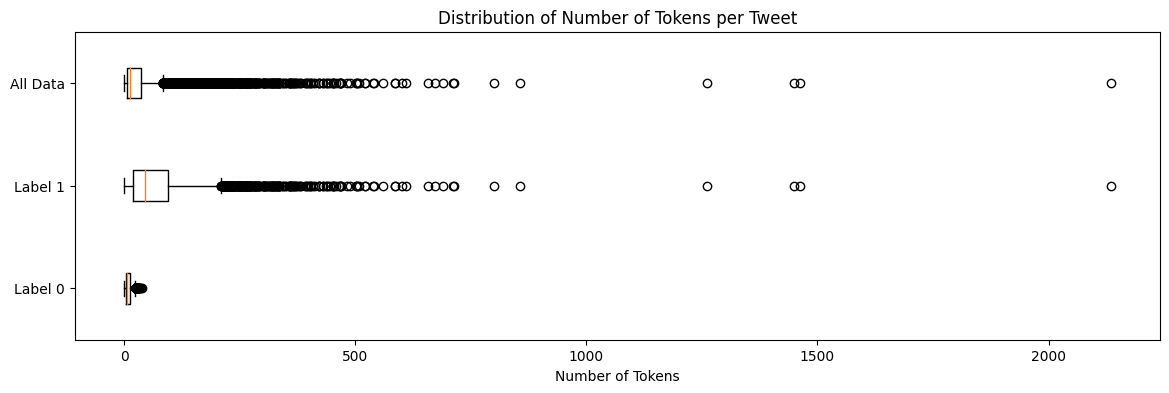

Combined Statistics:
  Statistic      Label 0      Label 1     All Data
0     count  5121.000000  3998.000000  9119.000000
1      mean     8.977543    73.830415    37.410681
2       std     6.474626    96.862836    71.917229
3       min     0.000000     0.000000     0.000000
4       25%     4.000000    19.000000     6.000000
5       50%     7.000000    46.000000    12.000000
6       75%    12.000000    95.000000    37.000000
7       max    38.000000  2134.000000  2134.000000


In [4]:
# Plotting token distribution
label_0 = df[df['intention'] == 0]['tokens'].apply(len)
label_1 = df[df['intention'] == 1]['tokens'].apply(len)
all_data = df['tokens'].apply(len)

data = [label_0, label_1, all_data]
labels = ['Label 0', 'Label 1', 'All Data']

plt.figure(figsize=(14, 4))
plt.boxplot(data, labels=labels, vert=False)
plt.xlabel('Number of Tokens')
plt.title('Distribution of Number of Tokens per Tweet')
plt.show()

# Calculating statistics for token distribution
label_0_stats = label_0.describe()
label_1_stats = label_1.describe()
all_data_stats = all_data.describe()

# Creating a DataFrame to merge all statistics
stats_df = pd.DataFrame({
    'Statistic': label_0_stats.index,
    'Label 0': label_0_stats.values,
    'Label 1': label_1_stats.values,
    'All Data': all_data_stats.values
})

print("Combined Statistics:")
print(stats_df)


## 0.4. Distribution Box Plots (without outliers)

Number of outliers detected and removed:
Label 0: 246
Label 1: 258
All Data: 1171


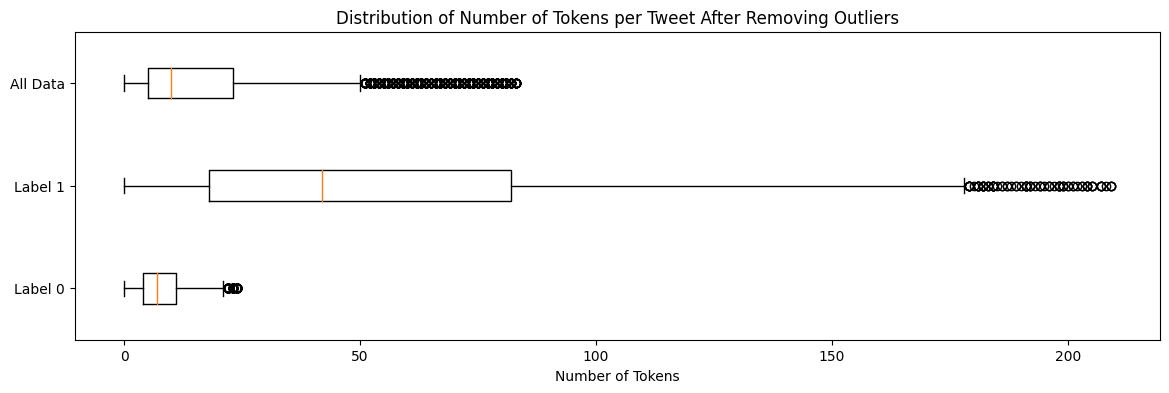

Combined Statistics After Removing Outliers:
     Statistic      Label 0      Label 1     All Data
0        count  4875.000000  3740.000000  7948.000000
1         mean     8.088615    55.705615    17.417967
2          std     5.235875    47.817387    18.375430
3          min     0.000000     0.000000     0.000000
4          25%     4.000000    18.000000     5.000000
5          50%     7.000000    42.000000    10.000000
6          75%    11.000000    82.000000    23.000000
7          max    24.000000   209.000000    83.000000
8  Lower Bound    -8.000000   -95.000000   -40.500000
9  Upper Bound    24.000000   209.000000    83.500000


In [5]:
# Detecting and removing outliers using IQR method
def remove_outliers(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data >= lower_bound) & (data <= upper_bound)], lower_bound, upper_bound

# Removing outliers for each label and all data
label_0_no_outliers, lb_0, ub_0 = remove_outliers(label_0)
label_1_no_outliers, lb_1, ub_1 = remove_outliers(label_1)
all_data_no_outliers, lb_all, ub_all = remove_outliers(all_data)

# Displaying the number of outliers detected and removed
outliers_label_0 = len(label_0) - len(label_0_no_outliers)
outliers_label_1 = len(label_1) - len(label_1_no_outliers)
outliers_all_data = len(all_data) - len(all_data_no_outliers)

print(f"Number of outliers detected and removed:")
print(f"Label 0: {outliers_label_0}")
print(f"Label 1: {outliers_label_1}")
print(f"All Data: {outliers_all_data}")

# Plotting token distribution after removing outliers
data_no_outliers = [label_0_no_outliers, label_1_no_outliers, all_data_no_outliers]
labels_no_outliers = ['Label 0', 'Label 1', 'All Data']

plt.figure(figsize=(14, 4))
plt.boxplot(data_no_outliers, labels=labels_no_outliers, vert=False)
plt.xlabel('Number of Tokens')
plt.title('Distribution of Number of Tokens per Tweet After Removing Outliers')
plt.show()

# Calculating statistics after removing outliers
label_0_stats_no_outliers = label_0_no_outliers.describe()
label_1_stats_no_outliers = label_1_no_outliers.describe()
all_data_stats_no_outliers = all_data_no_outliers.describe()

# Combined Statistics After Removing Outliers
stats_no_outliers_df = pd.DataFrame({
    'Statistic': label_0_stats_no_outliers.index.tolist() + ['Lower Bound', 'Upper Bound'],
    'Label 0': label_0_stats_no_outliers.values.tolist() + [lb_0, ub_0],
    'Label 1': label_1_stats_no_outliers.values.tolist() + [lb_1, ub_1],
    'All Data': all_data_stats_no_outliers.values.tolist() + [lb_all, ub_all]
})

print("Combined Statistics After Removing Outliers:")
print(stats_no_outliers_df)


# Part 1: Feature Vectors

## 1.1. Loading Word2Vec model

In [6]:
# print available word2vec models
print("\n".join(api.info()['models'].keys()))


fasttext-wiki-news-subwords-300
conceptnet-numberbatch-17-06-300
word2vec-ruscorpora-300
word2vec-google-news-300
glove-wiki-gigaword-50
glove-wiki-gigaword-100
glove-wiki-gigaword-200
glove-wiki-gigaword-300
glove-twitter-25
glove-twitter-50
glove-twitter-100
glove-twitter-200
__testing_word2vec-matrix-synopsis


In [7]:
# Set the path to where you want to save the Word2Vec model
W2V_PATH = "/content/word2vec-google-news-300.model"

# Create the directory if it doesn't exist
os.makedirs(os.path.dirname(W2V_PATH), exist_ok=True)

# Load or download the Word2Vec model
if os.path.exists(W2V_PATH):
    print("Loading Word2Vec model...")
    w2v_model = gensim.models.KeyedVectors.load(W2V_PATH, mmap='r')
    print("Word2Vec model is loaded.")
else:
    print("Downloading Word2Vec model...")
    w2v_model = api.load("word2vec-google-news-300")
    print("Word2vec model is downloaded.")
    print("\nSaving Word2Vec model...")
    w2v_model.save(W2V_PATH)
    print("Word2Vec model is saved.")


[==================================================] 100.0% 1662.8/1662.8MB downloaded
Word2vec model is downloaded.

Saving Word2Vec model...
Word2Vec model is saved.


## 1.2. Dataset Class

In [8]:
class Twitter(Dataset):
    def __init__(self, dataframe: pd.DataFrame, w2v_model: gensim.models.KeyedVectors, sequence_len: int):
        self.dataframe = dataframe
        self.w2v_model = w2v_model
        self.max_sequence_len = sequence_len
        self.vector_size = w2v_model.vector_size

        self.df_token_col = "tokens"

        self._proc_dataset()

        self.len = len(self.dataframe)

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        return self.dataframe.iloc[idx]["vector"], self.dataframe.iloc[idx]["intention"]

    def get_vector_size(self):
        return self.vector_size

    def _proc_dataset(self):
        # Preprocess and return tokens list
        self.dataframe[self.df_token_col] = self.dataframe["tweet"].map(preprocess_text)

        # Delete samples with empty tokens
        lwz = len(self.dataframe)
        self.dataframe = self.dataframe[self.dataframe[self.df_token_col].map(len) > 0]
        self.dataframe.reset_index(drop=True, inplace=True)
        print(f"Deleted 0-Len Samples: {lwz - len(self.dataframe)}")

        # Add padding
        self.dataframe[self.df_token_col] = self.dataframe[self.df_token_col].map(self._pad)

        # Get embedding's vectors
        self.dataframe["vector"] = self.dataframe[self.df_token_col].map(self._get_word_vectors)

    def _get_word_vectors(self, tokens: list) -> torch.tensor:
        vectors = []
        for token in tokens:
            if token in self.w2v_model:
                vectors.append(self.w2v_model[token])
            else:
                vectors.append(np.zeros(self.vector_size))
        return self._to_tensor(vectors)

    def _pad(self, tokens: list):
        if len(tokens) > self.max_sequence_len:
            return tokens[:self.max_sequence_len]
        else:
            padding = [""] * (self.max_sequence_len - len(tokens))
            return tokens + padding

    def seq_report(self):
        length_all = self.dataframe[self.df_token_col].map(len).tolist()
        max_length = np.max(length_all)
        print(f"Sequence Length Report")
        print(f":::::MAX  LENGTH:::[{max_length:^5}]")
        print(f":::::MIN  LENGTH:::[{np.min(length_all):^5}]")
        print(f":::::MEAN LENGTH:::[{np.mean(length_all):^5}]")

        all_tokens = set()
        for token_set in self.dataframe[self.df_token_col].tolist():
            all_tokens = all_tokens.union(set(token_set))
        unique_tokens_count = len(all_tokens)
        valid_tokens = sum(1 if token in self.w2v_model else 0 for token in all_tokens)
        print("Sequence Tokenization Report")
        print(f":::::All Unique Tokens:::[{unique_tokens_count:^6}]")
        print(f":::::All Valid Tokens:::[{valid_tokens:^6}]")
        print(f":::::Valid Tokens:::[{round(100 * valid_tokens / unique_tokens_count, 2):^5}%]")

    @staticmethod
    def _to_tensor(tokens: list):
        return torch.tensor(tokens, dtype=torch.float32)


## QUESTION: Methods of dealing with non-existing words in dictionary

When dealing with non-existent words in a dictionary, especially in the context of word embeddings like Word2Vec, several methods can be employed to handle them. Here are some common methods along with their advantages and disadvantages:

***

**1. Zero Vectors or Zero Padding:**

Method:
> For any word not present in the dictionary, assign a zero vector (a vector of all zeros) of the same dimensionality as the word embeddings.

Advantages:
> Simple and straightforward to implement.
Maintains the dimensionality of the input data, ensuring consistency in input shape.
Can be useful for padding shorter sequences to match the length of longer sequences.

Disadvantages:
> Does not capture any semantic information about the missing words.
May introduce noise to the model, especially if a significant portion of the vocabulary is missing.
The model may not effectively learn from zero vectors, potentially impacting performance.

***

**2. Random Initialization:**

Method:
> Initialize the embeddings for non-existent words randomly. This involves generating random vectors for out-of-vocabulary words.

Advantages:
> Provides some representation for missing words, potentially capturing relationships with other words through random initialization.
Can help prevent overfitting by introducing variability in the embeddings.
    
Disadvantages:
> Lack of semantic coherence: Randomly initialized vectors may not capture meaningful semantic relationships.
Unpredictable behavior: Since the vectors are randomly generated, they may not generalize well across different runs or datasets.
May not effectively capture relationships between missing words and existing words in the vocabulary.

***

**3. Subword Embeddings:**

Method:
> Use subword embeddings or character-level embeddings to represent words. Instead of having embeddings for entire words, the model learns embeddings for subword units such as character n-grams or morphemes.

Advantages:
> Can handle unseen or out-of-vocabulary words by leveraging morphological information present in the training data.
Provides a more fine-grained representation of words, capturing meaningful subword information.
Helps generalize to unseen words with similar subword structures.

Disadvantages:
> Increased computational complexity: Generating subword embeddings requires additional processing compared to word-level embeddings.
May require larger training datasets to effectively capture subword patterns.
Subword embeddings may not capture higher-level semantic relationships present in full words.

***

**4. External Knowledge or Domain-specific Embeddings:**

Method:
> Utilize pre-trained embeddings from external sources or domain-specific vocabularies to represent out-of-vocabulary words.

Advantages:
> Leverages external knowledge sources or domain-specific vocabularies to provide meaningful representations for missing words.
Can capture domain-specific semantics and relationships that may not be present in generic embeddings.
    
Disadvantages:
> Dependency on external resources: Requires access to pre-trained embeddings or domain-specific knowledge bases.
May introduce bias: External embeddings may contain biases present in the training data, which can influence model behavior.
Limited generalizability: Domain-specific embeddings may not generalize well to other domains or tasks.

***

Each method has its own trade-offs in terms of simplicity, effectiveness, and computational cost. The choice of method depends on factors such as the specific task, the characteristics of the dataset, and the computational resources available.

# Part 2: CNN Classification

## 2.1. Preparing Data

### QUESTION: Adam vs SGD optimizer

**Adam Optimizer:**

> The Adam optimizer is an adaptive optimization algorithm commonly used in training deep learning models. It adapts the learning rate for each parameter individually based on estimates of the first and second moments of the gradients.

***

**Adaptive Learning Rates:**
- Adam adjusts the learning rates for each parameter adaptively based on the magnitude of the gradients. This allows it to handle sparse gradients and noisy data more effectively than SGD, which uses a fixed learning rate.
- SGD uses a fixed learning rate for all parameters, which may require manual tuning and can lead to suboptimal convergence in certain scenarios.

**Momentum:**
- Adam incorporates momentum by keeping an exponentially decaying average of past gradients. This helps smooth out the optimization process and accelerates convergence, especially in the presence of noise or high curvature in the loss landscape.
- SGD with momentum also includes momentum, but it doesn't adaptively adjust the learning rate. This can lead to overshooting or slow convergence in some cases.

**Bias Correction:**
- Adam performs bias correction for the estimates of the first and second moments of the gradients. This correction is crucial, especially when the momentum decay rate is close to one, as it helps maintain stability during training.
- SGD doesn't perform bias correction, which can lead to biased estimates of the gradients and affect convergence speed and stability.

**Initialization:**
- Adam requires less tuning of the learning rate hyperparameter compared to SGD. It's less sensitive to the choice of initial learning rate and can adaptively adjust it during training based on the gradients' behavior.
- SGD's performance can be sensitive to the choice of initial learning rate, and manual tuning may be necessary to achieve optimal results.

**Efficiency:**
- Adam converges faster than SGD in many scenarios due to its adaptive learning rates, momentum, bias correction, and efficient initialization. It quickly adapts to changes in the loss landscape and provides robust and efficient optimization.
- SGD's convergence can be slower, especially in the presence of noisy gradients or ill-conditioned optimization landscapes, as it relies on a fixed learning rate for all parameters.

### QUESTION: Cross Entropy Loss Function

The Cross Entropy cost function, also known as the log loss function, is commonly used in classification tasks, particularly in scenarios involving multiple classes.

In the context of our problem, which involves classifying constructed vectors, the Cross Entropy cost function is well-suited for several reasons:

- **Suitability for Multi-Class Classification:** The Cross Entropy loss function is appropriate for multi-class classification problems, where each input sample can belong to one of multiple classes. In our case, the constructed vectors likely represent features that need to be classified into different categories or classes.

- **Softmax Activation Compatibility:** The Cross Entropy loss function is often paired with the softmax activation function in the output layer of neural networks for multi-class classification tasks. Softmax ensures that the output of the model represents class probabilities, with each value indicating the likelihood of the input belonging to a particular class. Cross Entropy loss complements softmax by penalizing the model based on the discrepancy between predicted probabilities and true class labels.

- **Effective Gradient Computation:** The Cross Entropy loss function yields gradients that are well-suited for backpropagation, the algorithm used to update the model's parameters during training. The gradient of the Cross Entropy loss with respect to the model's parameters provides meaningful guidance for adjusting the weights and biases to minimize the loss function, thereby improving the model's classification accuracy over time.

- **Handles Class Imbalance:** Cross Entropy loss inherently accounts for class imbalances in the dataset, making it robust to scenarios where certain classes have more samples than others. By penalizing misclassifications based on the logarithm of predicted probabilities, Cross Entropy loss effectively addresses class imbalances by assigning higher penalties to misclassifications of rare classes.

- **Logarithmic Scoring:** The logarithmic nature of the Cross Entropy loss function makes it sensitive to the confidence of the model's predictions. It penalizes confidently incorrect predictions more heavily than uncertain predictions, which encourages the model to output well-calibrated probabilities for each class, leading to more reliable and interpretable results.

### 2.1.1 Split Data into Train-Valid

In [9]:
# Split dataset into train-test split
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=28)


### QUESTION: Split Ratio

**Reported Ratio:**
> The ratio of the division is 80% for the training set and 20% for the validation set.

**Reasoning:**
> The 80-20 ratio is a commonly used split in machine learning because it strikes a balance between having enough data for training and having enough data for validation.

> While variations in the split ratio can be made based on specific dataset characteristics and modeling goals, the 80-20 split is a practical choice that provides a reasonable amount of data for both training and validation.

### 2.1.2 Create Datasets

In [10]:
# Create twitter datasets
train_dataset = Twitter(
    dataframe=train_df,
    w2v_model=w2v_model,
    sequence_len=64
)
valid_dataset = Twitter(
    dataframe=valid_df,
    w2v_model=w2v_model,
    sequence_len=64
)
print("\n")
print('=' * 120)
print(f"Train dataset length: {len(train_dataset)}")
print(f"Valid dataset length: {len(valid_dataset)}")
print('=' * 120)
print("\n")


Deleted 0-Len Samples: 23


<ipython-input-8-6dd2cb6c0566>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataframe[self.df_token_col] = self.dataframe[self.df_token_col].map(self._pad)
<ipython-input-8-6dd2cb6c0566>:75: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  return torch.tensor(tokens, dtype=torch.float32)
<ipython-input-8-6dd2cb6c0566>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.or

Deleted 0-Len Samples: 9


<ipython-input-8-6dd2cb6c0566>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataframe[self.df_token_col] = self.dataframe[self.df_token_col].map(self._pad)




Train dataset length: 7272
Valid dataset length: 1815




<ipython-input-8-6dd2cb6c0566>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataframe["vector"] = self.dataframe[self.df_token_col].map(self._get_word_vectors)


## 2.2. Model & Train

### 2.2.1 Utils

#### Model Evaluation

In [11]:
@torch.no_grad()
def model_eval(model, loader, loss_function, device: Literal['cuda', 'cpu', 'auto']):
    """Returns test_loss, test_acc"""
    test_loss = 0.0
    test_acc = 0.0
    total = 0
    correct = 0

    if device == "auto":
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = model.to(device)
    itr = tqdm(loader, total=len(loader), leave=False)

    for inputs, labels in itr:
        # Move model's inputs to `device`
        inputs, labels = inputs.to(device), labels.to(device)

        # Use model's forward pass to generate outputs
        outputs = model(inputs)

        # Calculate model's loss
        loss = loss_function(outputs, labels)
        test_loss += loss.item()

        # Calculate/update model's accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        test_acc = correct / total

        itr.set_description("(Eval)")
        itr.set_postfix(
            loss=round(loss.item(), 5),
            accuracy=round(test_acc, 5),
        )

    test_loss /= len(loader)
    return test_loss, test_acc


#### Model Train

In [12]:
def train_model(
        model,
        batch_size,
        loss_function,
        optimizer,
        epochs,
        train_set,
        valid_set,
        device: Literal['cuda', 'cpu', 'auto'],
):

    if device == "auto":
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.to(device)

    train_losses = []
    train_accs = []
    valid_losses = []
    valid_accs = []

    # Create dataloaders from datasets
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False)

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0
        epoch_acc = 0.0
        total = 0
        correct = 0
        itr = tqdm(train_loader, total=len(train_loader), leave=False)

        for inputs, labels in itr:
            # Move model's inputs to `device`
            inputs, labels = inputs.to(device), labels.to(device)

            # Use model's forward pass to generate outputs
            outputs = model(inputs)

            # Process model's predictions and calculate/update accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            epoch_acc = correct / total

            # Calculate model's loss and update epoch's loss
            loss = loss_function(outputs, labels)
            epoch_loss += loss.item()

            # 1. Clear optimizer's state and zero prev grads,
            # 2. Backward calculated loss
            # 3. Step optimizer
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            itr.set_description(f"(Training) Epoch [{epoch + 1}/{epochs}]")
            itr.set_postfix(
                loss=round(loss.item(), 5),
                accuracy=round(epoch_acc, 5),
            )

        train_losses.append(epoch_loss / len(train_loader))
        train_accs.append(epoch_acc)

        model.eval()
        valid_loss, valid_acc = model_eval(
            model=model,
            loader=valid_loader,
            loss_function=loss_function,
            device=device
        )

        valid_losses.append(valid_loss)
        valid_accs.append(valid_acc)

    history = {
        "train_loss": train_losses,
        "train_acc": train_accs,
        "valid_loss": valid_losses,
        "valid_acc": valid_accs,
    }
    return history


#### Trend Plot

In [13]:
def trend_plot_helper(pobj):
    plt.figure(figsize=(5*len(pobj), 5))
    for idx, (titler, plots) in enumerate(pobj.items(), start=1):
        plt.subplot(1, len(pobj), idx)
        for label, trend in plots:
            plt.plot(range(1, len(trend)+1), trend, label=label)
        yt, xt = titler.split(' - ')
        plt.xlabel(xt)
        plt.ylabel(yt)
        plt.legend()


#### Confusion Matrix

In [14]:
@torch.no_grad()
def generate_confusion_matrix(model, dataset, device='auto'):
    if device == 'auto':
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    loader = DataLoader(dataset, batch_size=32, shuffle=False)
    itr = tqdm(loader, leave=False, desc="Generate data")

    labels = []
    predicted = []

    for inputs, lbls in itr:
        inputs, lbls = inputs.to(device), lbls.to(device)

        # Predict the labels
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        labels.extend(lbls.cpu().numpy())
        predicted.extend(preds.cpu().numpy())

    cm = metrics.confusion_matrix(
        y_true=labels,
        y_pred=predicted,
    )

    plt.figure(figsize=(4,4))
    sns.heatmap(cm, cmap='Blues', annot=True, cbar=False, fmt=".0f",)
    plt.xlabel('Predicted Label', labelpad=20)
    plt.ylabel('True Label', labelpad=20)
    plt.title('Confusion Matrix', fontsize=30)

    recall = metrics.recall_score(y_true=labels, y_pred=predicted, average='macro', zero_division=1)
    f1 = metrics.f1_score(y_true=labels, y_pred=predicted, average='macro', zero_division=1)
    precision = metrics.precision_score(y_true=labels, y_pred=predicted, average='macro', zero_division=1)
    report = metrics.classification_report(y_true=labels, y_pred=predicted)

    return {'recall': recall, 'f1': f1, 'precision': precision, 'report': report}


### 2.2.2 Model's Network

In [15]:
class CNN(nn.Module):
    def __init__(self, cnn_filters):
        super(CNN, self).__init__()
        self.conv1_3 = nn.Conv1d(in_channels=300, out_channels=cnn_filters, kernel_size=3)
        self.conv1_5 = nn.Conv1d(in_channels=300, out_channels=cnn_filters, kernel_size=5)
        self.conv1_7 = nn.Conv1d(in_channels=300, out_channels=cnn_filters, kernel_size=7)
        self.conv2_3 = nn.Conv1d(in_channels=cnn_filters, out_channels=cnn_filters*2, kernel_size=3)
        self.conv2_5 = nn.Conv1d(in_channels=cnn_filters, out_channels=cnn_filters*2, kernel_size=5)
        self.conv2_7 = nn.Conv1d(in_channels=cnn_filters, out_channels=cnn_filters*2, kernel_size=7)
        self.pool = nn.AdaptiveMaxPool1d(1)  # This is the local max pooling layer
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(3 * cnn_filters*2, 128)
        self.fc2 = nn.Linear(128, 2)
        self.relu = nn.ReLU()

    def forward(self, x):
        # Transpose the input to match the shape expected by Conv1d
        x = x.transpose(1, 2)

        x1 = self.relu(self.conv1_3(x))
        x2 = self.relu(self.conv1_5(x))
        x3 = self.relu(self.conv1_7(x))

        x1 = self.pool(self.relu(self.conv2_3(x1)))  # Applying max pooling after second level of convolution layers
        x2 = self.pool(self.relu(self.conv2_5(x2)))  # Applying max pooling after second level of convolution layers
        x3 = self.pool(self.relu(self.conv2_7(x3)))  # Applying max pooling after second level of convolution layers

        x = torch.cat((x1, x2, x3), dim=1)
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x


### 2.2.3 Training

#### QUESTION: Kernel Size

The kernel size in convolutional layers plays a crucial role in determining the receptive field of the convolution operation and thereby influences the model's ability to extract input features effectively.

**Effect of Kernel Size:**

- Larger Kernel Size: A larger kernel size covers a broader area of the input data, resulting in a larger receptive field. This allows the convolutional layer to capture more global patterns and long-range dependencies in the input. However, larger kernel sizes may lead to increased computational complexity and the risk of overfitting if the model has insufficient data to learn from.

- Smaller Kernel Size: Conversely, a smaller kernel size focuses on a smaller local region of the input data, resulting in a smaller receptive field. Smaller kernel sizes are effective in capturing fine-grained details and local features in the input. They are often preferred when dealing with intricate patterns or when computational resources are limited.

**Effectiveness in Extracting Features:**

- Larger Kernel Size: Using larger kernel sizes is effective in extracting high-level features and capturing global spatial relationships within the input data. For example, in image classification tasks, larger kernel sizes can detect larger patterns such as object shapes or textures.

- Smaller Kernel Size: Smaller kernel sizes excel at capturing low-level features and subtle patterns in the input. They are particularly useful for tasks that require precise localization of features or when dealing with intricate structures with fine details.

**Meaning of More or Less:**

- The choice of kernel size depends on the specific characteristics of the data and the complexity of the patterns to be learned. Using larger kernel sizes can be beneficial when dealing with larger, more complex features or when context over a wider area is necessary. Conversely, smaller kernel sizes are preferred for capturing finer details and local variations in the input.

- However, there is no one-size-fits-all answer, and the selection of kernel size often involves experimentation and empirical validation. Finding the optimal kernel size involves striking a balance between capturing relevant features and controlling model complexity to prevent overfitting.

#### Model Training Config

In [16]:
LEARNING_RATES = [1e-4, 1e-3, 1e-2]
WEIGHT_DECAY = 1e-2
BATCH_SIZES = [16, 32, 64]
EPOCHS = 15

SEQUENCE_LEN = 64
CNN_FILTERS = 64

In [17]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#### Instantiate & Train Model | Classification Reports | Loss & Accuracy Plots | Confusion Matrices

Batch Size: 16, Learning Rate: 0.0001
Training Report:

Recall:    0.981
F1:        0.981
Precision: 0.982
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      4100
           1       0.98      0.97      0.98      3172

    accuracy                           0.98      7272
   macro avg       0.98      0.98      0.98      7272
weighted avg       0.98      0.98      0.98      7272



Validation Report:

Recall:    0.904
F1:        0.905
Precision: 0.908
              precision    recall  f1-score   support

           0       0.90      0.93      0.92       990
           1       0.92      0.87      0.89       825

    accuracy                           0.91      1815
   macro avg       0.91      0.90      0.91      1815
weighted avg       0.91      0.91      0.91      1815



Batch Size: 16, Learning Rate: 0.001
Training Report:

Recall:    0.974
F1:        0.975
Precision: 0.977
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      4100
           1       0.98      0.96      0.97      3172

    accuracy                           0.98      7272
   macro avg       0.98      0.97      0.98      7272
weighted avg       0.98      0.98      0.98      7272



Validation Report:

Recall:    0.896
F1:        0.897
Precision: 0.900
              precision    recall  f1-score   support

           0       0.89      0.93      0.91       990
           1       0.91      0.86      0.89       825

    accuracy                           0.90      1815
   macro avg       0.90      0.90      0.90      1815
weighted avg       0.90      0.90      0.90      1815



Batch Size: 16, Learning Rate: 0.01
Training Report:

Recall:    0.883
F1:        0.883
Precision: 0.883
              precision    recall  f1-score   support

           0       0.90      0.90      0.90      4100
           1       0.87      0.87      0.87      3172

    accuracy                           0.88      7272
   macro avg       0.88      0.88      0.88      7272
weighted avg       0.88      0.88      0.88      7272



Validation Report:

Recall:    0.870
F1:        0.871
Precision: 0.873
              precision    recall  f1-score   support

           0       0.87      0.90      0.88       990
           1       0.87      0.84      0.86       825

    accuracy                           0.87      1815
   macro avg       0.87      0.87      0.87      1815
weighted avg       0.87      0.87      0.87      1815



Batch Size: 32, Learning Rate: 0.0001
Training Report:

Recall:    0.964
F1:        0.967
Precision: 0.970
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      4100
           1       0.99      0.94      0.96      3172

    accuracy                           0.97      7272
   macro avg       0.97      0.96      0.97      7272
weighted avg       0.97      0.97      0.97      7272



Validation Report:

Recall:    0.902
F1:        0.906
Precision: 0.913
              precision    recall  f1-score   support

           0       0.88      0.96      0.92       990
           1       0.94      0.85      0.89       825

    accuracy                           0.91      1815
   macro avg       0.91      0.90      0.91      1815
weighted avg       0.91      0.91      0.91      1815



Batch Size: 32, Learning Rate: 0.001
Training Report:

Recall:    0.970
F1:        0.972
Precision: 0.975
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      4100
           1       0.99      0.95      0.97      3172

    accuracy                           0.97      7272
   macro avg       0.97      0.97      0.97      7272
weighted avg       0.97      0.97      0.97      7272



Validation Report:

Recall:    0.904
F1:        0.907
Precision: 0.915
              precision    recall  f1-score   support

           0       0.88      0.96      0.92       990
           1       0.94      0.85      0.89       825

    accuracy                           0.91      1815
   macro avg       0.91      0.90      0.91      1815
weighted avg       0.91      0.91      0.91      1815



Batch Size: 32, Learning Rate: 0.01
Training Report:

Recall:    0.881
F1:        0.875
Precision: 0.874
              precision    recall  f1-score   support

           0       0.93      0.84      0.88      4100
           1       0.82      0.92      0.87      3172

    accuracy                           0.88      7272
   macro avg       0.87      0.88      0.87      7272
weighted avg       0.88      0.88      0.88      7272



Validation Report:

Recall:    0.859
F1:        0.856
Precision: 0.856
              precision    recall  f1-score   support

           0       0.90      0.83      0.86       990
           1       0.81      0.89      0.85       825

    accuracy                           0.86      1815
   macro avg       0.86      0.86      0.86      1815
weighted avg       0.86      0.86      0.86      1815



Batch Size: 64, Learning Rate: 0.0001
Training Report:

Recall:    0.951
F1:        0.952
Precision: 0.954
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      4100
           1       0.96      0.93      0.95      3172

    accuracy                           0.95      7272
   macro avg       0.95      0.95      0.95      7272
weighted avg       0.95      0.95      0.95      7272



<ipython-input-14-6e69c280aaaf>:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(4,4))


Validation Report:

Recall:    0.903
F1:        0.905
Precision: 0.908
              precision    recall  f1-score   support

           0       0.89      0.94      0.92       990
           1       0.92      0.87      0.89       825

    accuracy                           0.91      1815
   macro avg       0.91      0.90      0.91      1815
weighted avg       0.91      0.91      0.91      1815



Batch Size: 64, Learning Rate: 0.001
Training Report:

Recall:    0.976
F1:        0.976
Precision: 0.977
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      4100
           1       0.98      0.97      0.97      3172

    accuracy                           0.98      7272
   macro avg       0.98      0.98      0.98      7272
weighted avg       0.98      0.98      0.98      7272



Validation Report:

Recall:    0.903
F1:        0.905
Precision: 0.906
              precision    recall  f1-score   support

           0       0.90      0.93      0.91       990
           1       0.91      0.88      0.89       825

    accuracy                           0.91      1815
   macro avg       0.91      0.90      0.90      1815
weighted avg       0.91      0.91      0.91      1815



Batch Size: 64, Learning Rate: 0.01
Training Report:

Recall:    0.913
F1:        0.916
Precision: 0.921
              precision    recall  f1-score   support

           0       0.91      0.95      0.93      4100
           1       0.94      0.87      0.90      3172

    accuracy                           0.92      7272
   macro avg       0.92      0.91      0.92      7272
weighted avg       0.92      0.92      0.92      7272



Validation Report:

Recall:    0.896
F1:        0.898
Precision: 0.903
              precision    recall  f1-score   support

           0       0.88      0.94      0.91       990
           1       0.92      0.85      0.89       825

    accuracy                           0.90      1815
   macro avg       0.90      0.90      0.90      1815
weighted avg       0.90      0.90      0.90      1815



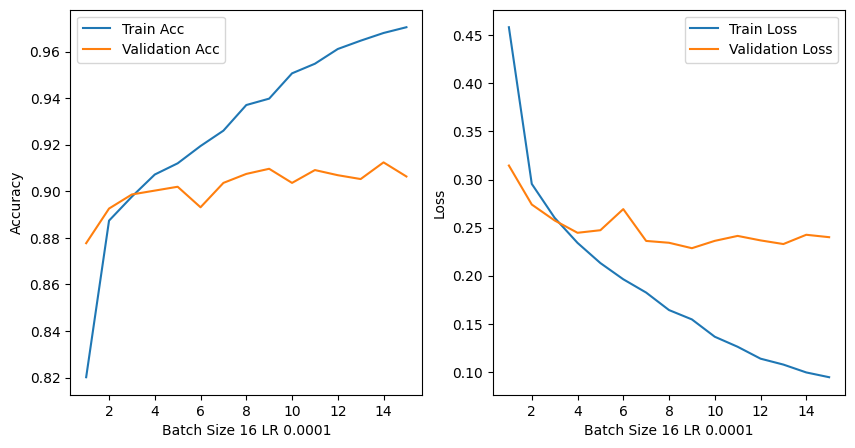

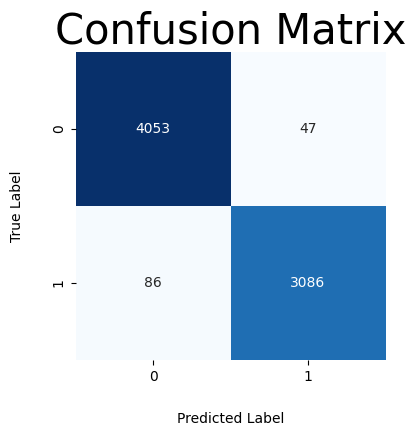

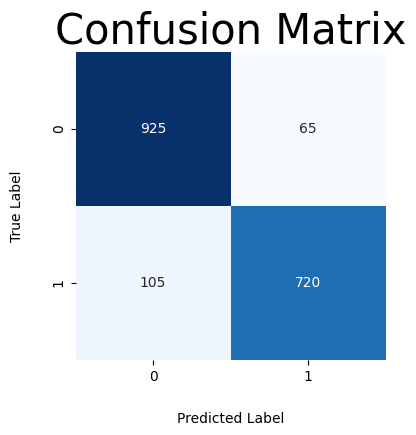

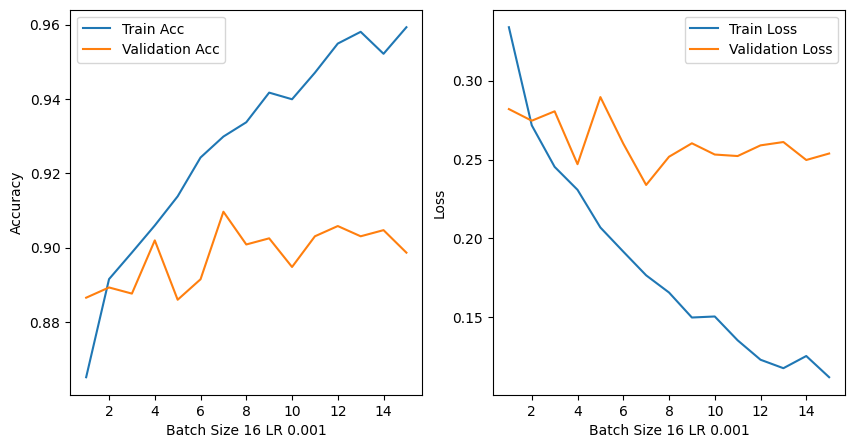

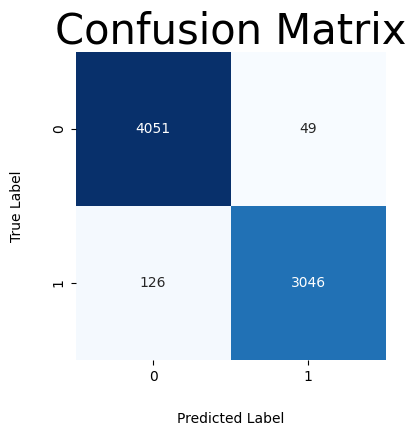

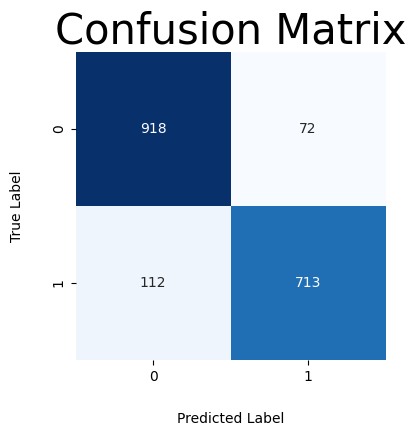

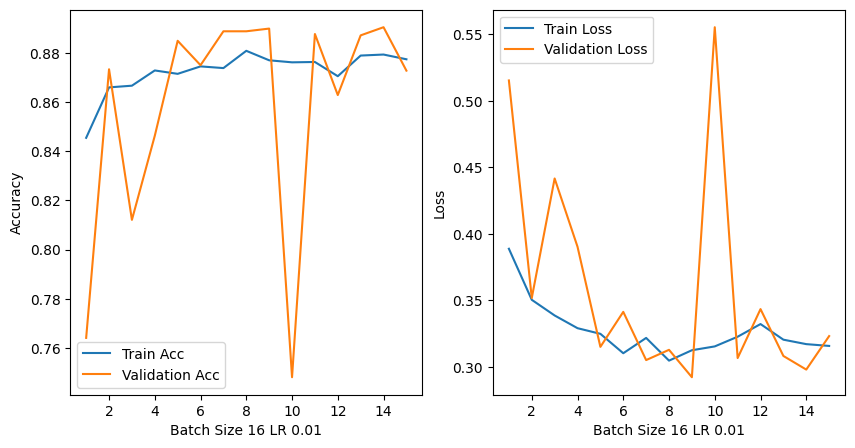

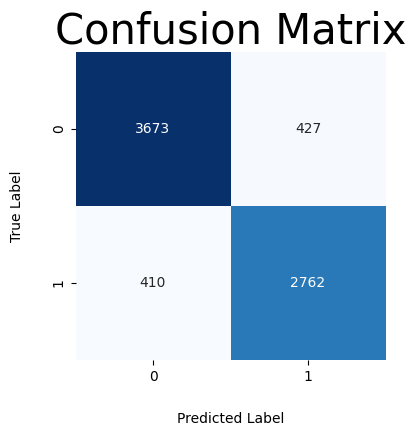

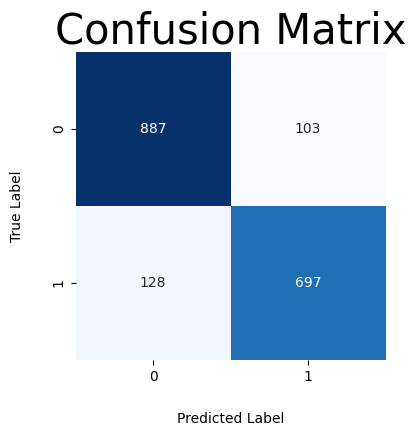

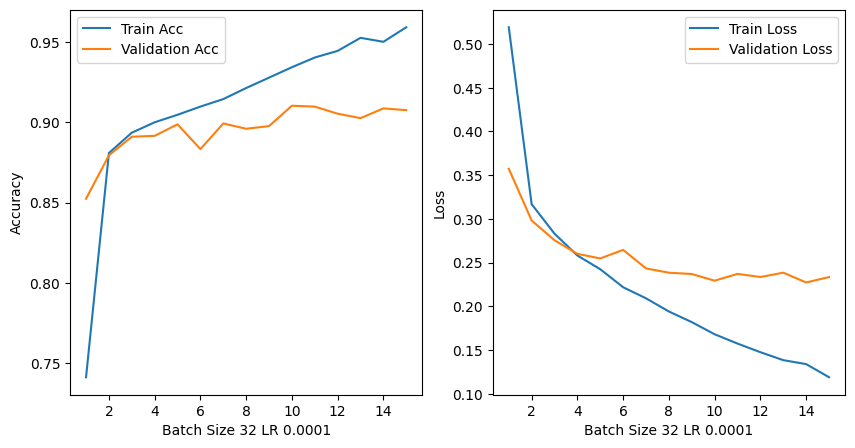

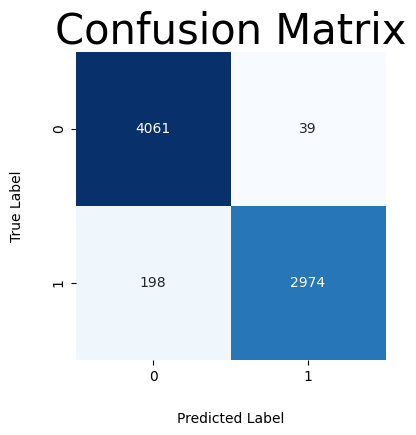

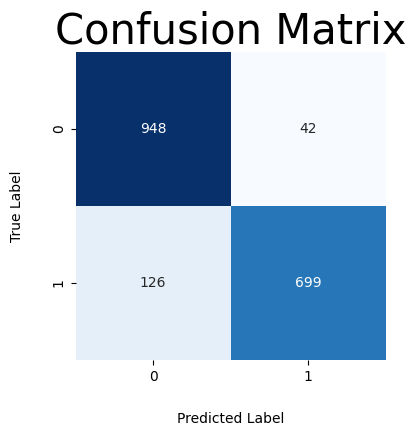

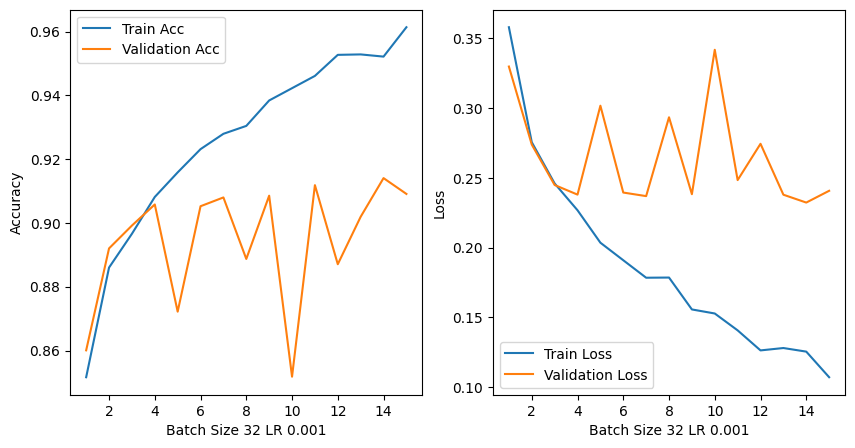

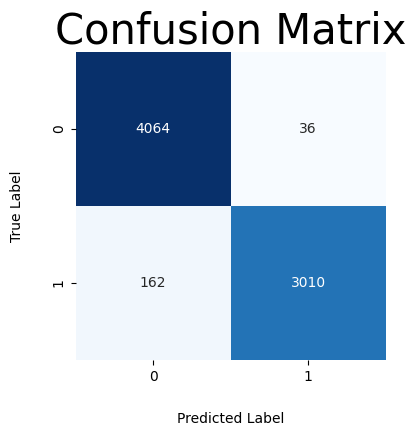

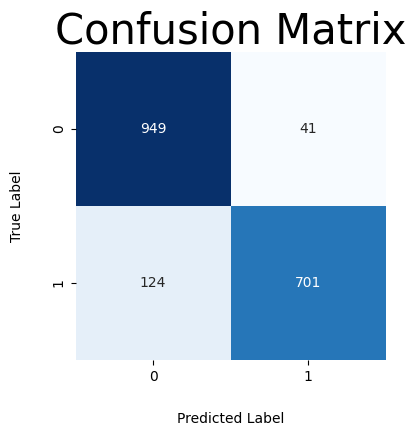

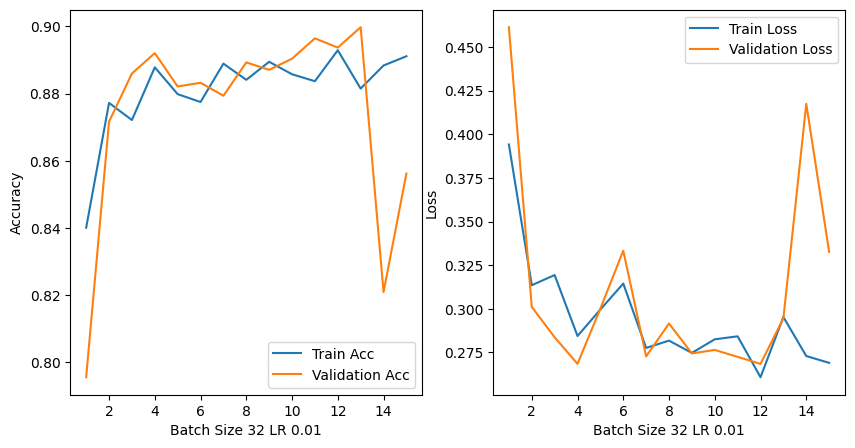

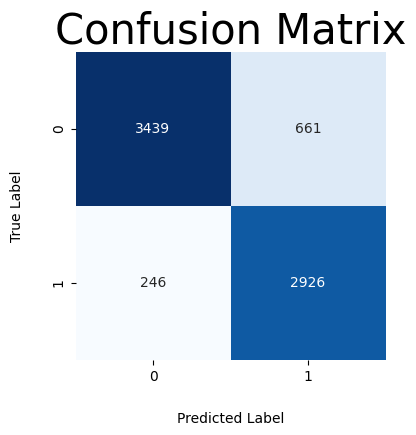

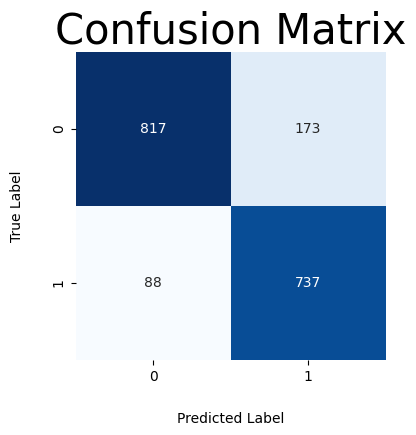

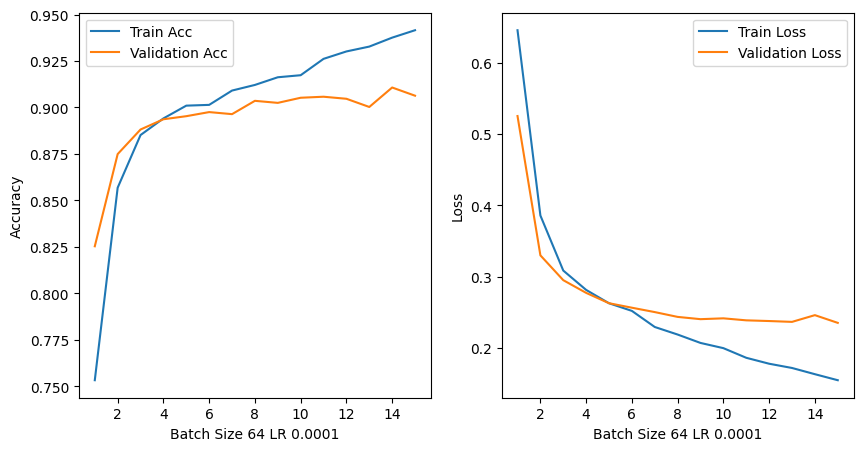

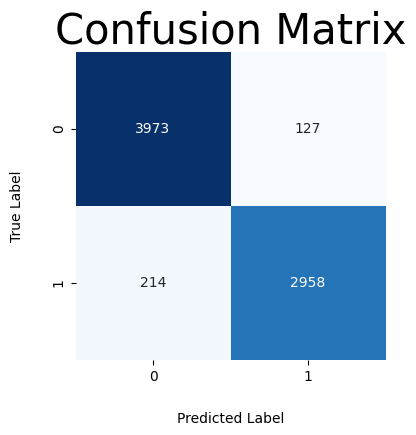

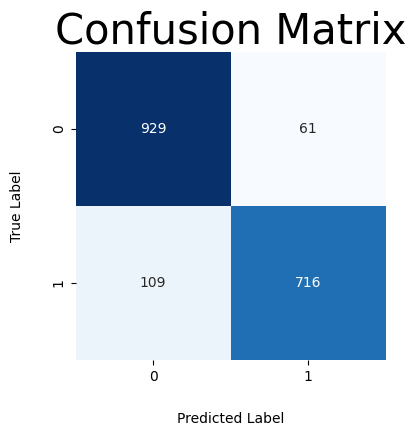

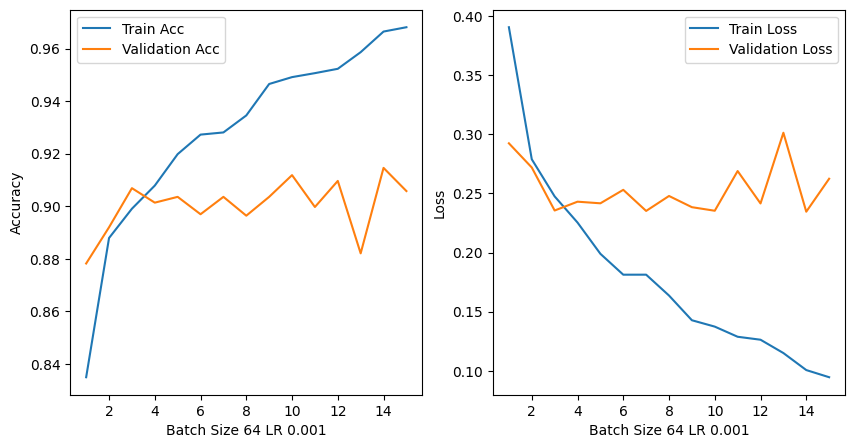

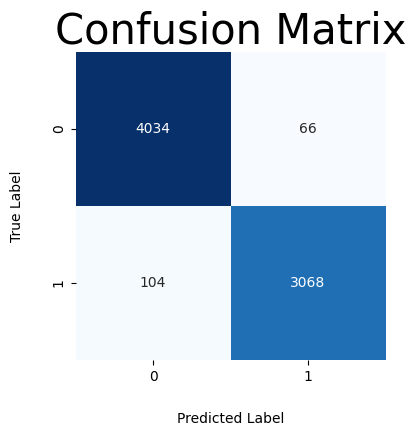

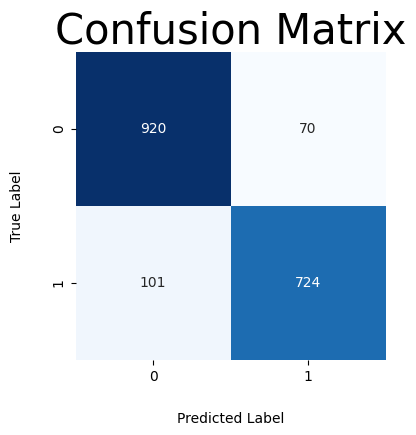

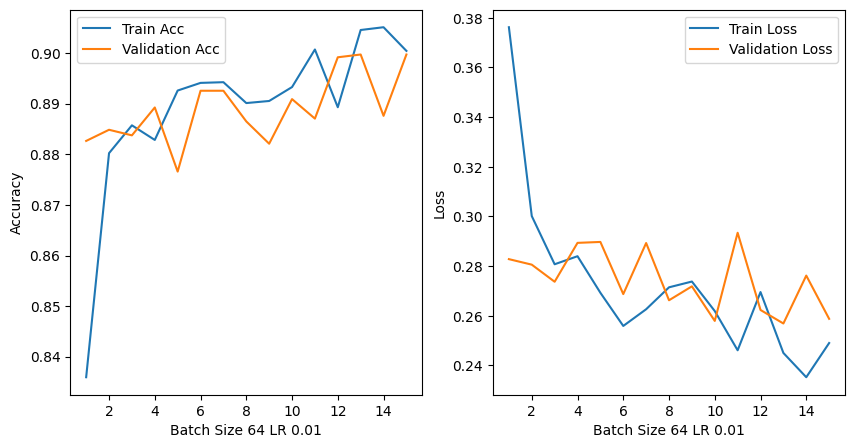

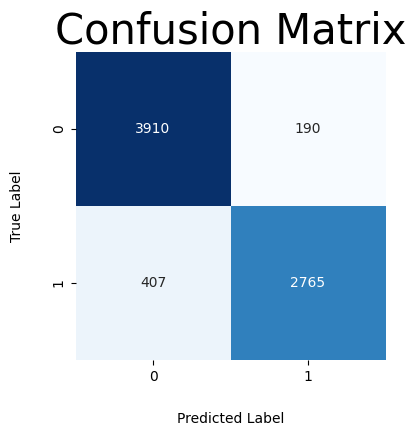

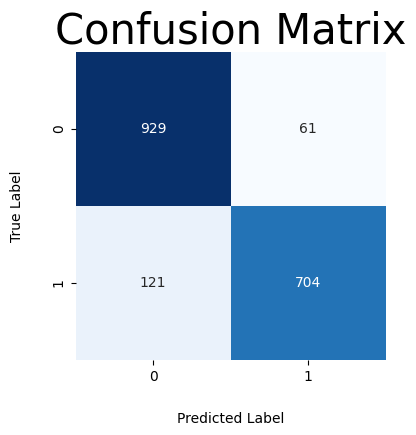

In [21]:
results = []

# Iterate over different batch sizes and initial learning rates
for batch_size in BATCH_SIZES:
    for learning_rate in LEARNING_RATES:
        # Define the model, optimizer, and other hyperparameters
        model = CNN(CNN_FILTERS)
        loss_function = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=WEIGHT_DECAY)
        epochs = EPOCHS

        # Train the model
        history = train_model(
            model=model,
            batch_size=batch_size,
            loss_function=loss_function,
            optimizer=optimizer,
            epochs=epochs,
            train_set=train_dataset,
            valid_set=valid_dataset,
            device=DEVICE
        )

        # Plot the training and validation loss and accuracy
        trend_plot_helper(
            {
                f"Accuracy - Batch Size {batch_size} LR {learning_rate}": [
                    ("Train Acc", history["train_acc"]),
                    ("Validation Acc", history["valid_acc"]),
                ],
                f"Loss - Batch Size {batch_size} LR {learning_rate}": [
                    ("Train Loss", history["train_loss"]),
                    ("Validation Loss", history["valid_loss"])
                ]
            }
        )

        # Generate the confusion matrix and classification report for training data
        train_cnn_model_report = generate_confusion_matrix(
            model=model,
            dataset=train_dataset,
        )

        # Generate the classification report for training data
        print('=' * 120)
        print(f"Batch Size: {batch_size}, Learning Rate: {learning_rate}")
        print('=' * 120)
        print("Training Report:\n")
        print(f"Recall:    {train_cnn_model_report['recall']:.3f}")
        print(f"F1:        {train_cnn_model_report['f1']:.3f}")
        print(f"Precision: {train_cnn_model_report['precision']:.3f}")
        print(train_cnn_model_report['report'])

        # Generate the confusion matrix and classification report for validation data
        valid_cnn_model_report = generate_confusion_matrix(
            model=model,
            dataset=valid_dataset,
        )

        # Generate the classification report for validation data
        print("Validation Report:\n")
        print(f"Recall:    {valid_cnn_model_report['recall']:.3f}")
        print(f"F1:        {valid_cnn_model_report['f1']:.3f}")
        print(f"Precision: {valid_cnn_model_report['precision']:.3f}")
        print(valid_cnn_model_report['report'])

        # Store the results for analysis
        results.append({
            'batch_size': batch_size,
            'learning_rate': learning_rate,
            'train_report': train_cnn_model_report,
            'valid_report': valid_cnn_model_report
        })


#### QUESTION: Feed Forward Layers

In many convolutional neural network (CNN) architectures, the reduction of feature dimensions is typically achieved through the use of pooling layers such as max pooling or average pooling. However, in the provided CNN architecture, the reduction of feature dimensions is done through feedforward (fully connected) layers instead of pooling layers. There could be several reasons for this design choice:

- **Flexibility in Dimensionality Reduction:** Using feedforward layers for dimensionality reduction offers more flexibility in controlling the reduction process. Pooling layers often have fixed parameters such as kernel size and stride, which may not be optimal for all datasets or tasks. On the other hand, feedforward layers allow for adjustable parameters such as the number of units and activation functions, providing greater control over the dimensionality reduction process.

- **Non-linear Transformation:** Feedforward layers introduce non-linear transformations to the extracted features, allowing the network to learn complex mappings between the input and output spaces. This can be beneficial for capturing intricate patterns and relationships in the data that may not be easily discernible through linear operations alone.

- **Adaptability to Task Complexity:** The use of feedforward layers enables the model to adapt to varying levels of task complexity. By adjusting the number of units and layers in the feedforward portion of the network, the model can accommodate tasks with different degrees of intricacy, ranging from simple classification to more sophisticated feature learning and representation.

- **End-to-End Learning:** Incorporating dimensionality reduction within the feedforward layers facilitates end-to-end learning, where the entire network, including the convolutional and feedforward layers, is trained jointly to optimize the desired objective function. This holistic optimization approach can lead to improved convergence and generalization performance compared to training separate components of the network independently.

- **Reduced Information Loss:** Pooling layers inherently discard some information during the pooling process, potentially leading to loss of discriminative features. In contrast, feedforward layers preserve more information by performing weighted combinations of all input features, thereby reducing the risk of information loss and enabling the model to retain more useful information for downstream tasks.


In [20]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

!jupyter nbconvert --to html "/content/AI_CA5_810899045.ipynb"

[NbConvertApp] Converting notebook /content/AI_CA5_810899045.ipynb to html
[NbConvertApp] ERROR | Notebook JSON is invalid: Additional properties are not allowed ('metadata' was unexpected)

Failed validating 'additionalProperties' in stream:

On instance['cells'][57]['outputs'][0]:
{'metadata': {'tags': None},
 'name': 'stderr',
 'output_type': 'stream',
 'text': ''}
[NbConvertApp] Writing 1801642 bytes to /content/AI_CA5_810899045.html
